In [1]:
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product
from dataclasses import dataclass
from uplift_dgf import get_daily_visitors, get_daily_conversions, grid_configs
from typing import List
from tqdm import tqdm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Set plot options
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")

In [3]:
# Set print options
np.set_printoptions(suppress=True, precision=4, edgeitems = 7)
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_columns', None)

In [4]:
# Create random generator
random_seed = 1923
rng = np.random.default_rng(random_seed)

## Set true parameters

In [5]:
# Avg. visitors per day & its noise, as Poisson distributions
lam_visitors = 100
lam_visitors_noise = 5

In [6]:
# Conversion rates
conversion_control = 0.15
conversion_experiment = 0.20
true_relative_uplift = (conversion_experiment /conversion_control) - 1

# Noise in conversion rates, as Beta distribution
# Mean = alpha / (alpha + beta)
conversion_noise_alpha = 3 
conversion_noise_beta = 100

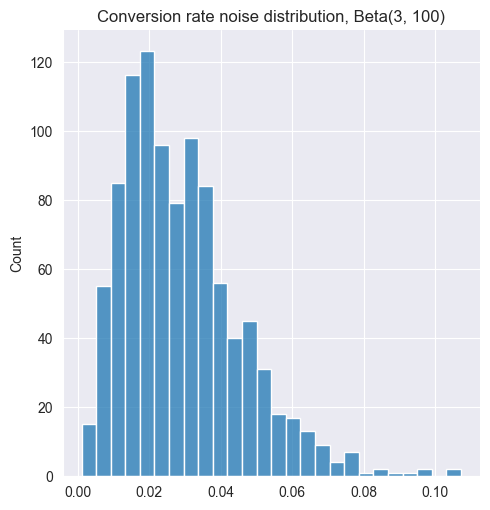

In [7]:
# Test conversion rate noise generation (will be randomly negated)
sns.displot(
    np.random.beta(conversion_noise_alpha, conversion_noise_beta, 1000)
)
_ = plt.title(f"Conversion rate noise distribution, Beta({conversion_noise_alpha}, {conversion_noise_beta})")

## Define data & model classes

In [8]:
@dataclass
class VariantData:
    visitors: int
    conversions: int

In [9]:
@dataclass
class ConversionPrior:
    alpha: float
    beta: float

In [10]:
class ConversionRateModel:

    def __init__(self, priors: List[ConversionPrior], data: List[VariantData], priors_label: str):

        # Set the conversion rate priors
        # 0: control, 1: experiment
        self.prior_control = priors[0]
        self.prior_experiment = priors[1]

        # Get experiment data
        # 0: control, 1: experiment
        self.visitors = [variant.visitors for variant in data]
        self.conversions = [variant.conversions for variant in data]

        self.priors_label = priors_label
        self.prior_predictive = None
        self.posterior_predictive = None
    
    def _create_model(self):

        # Define model
        with pm.Model() as model:

            # Conversion rate priors,
            conversion_rate_control = pm.Beta(
                "conversion_rate_control",
                alpha = self.prior_control.alpha,
                beta = self.prior_control.beta
            )

            conversion_rate_experiment = pm.Beta(
                "conversion_rate_experiment",
                alpha = self.prior_experiment.alpha,
                beta = self.prior_experiment.beta
            )

            # Likelihoods
            likelihood_control = pm.Binomial(
                "outcome_control",
                n = self.visitors[0],
                p = conversion_rate_control,
                observed = self.conversions[0]
            )

            likelihood_experiment = pm.Binomial(
                "outcome_experiment",
                n = self.visitors[1],
                p = conversion_rate_experiment,
                observed = self.conversions[1]
            )

            # Relative uplift
            relative_uplift = pm.Deterministic(
                "relative_uplift",
                (conversion_rate_experiment / conversion_rate_control) - 1
            )
            
        return model
    
    def get_prior_predictive(self, **kwargs):

        # Sample prior predictive distribution
        with self._create_model():
            self.prior_predictive = pm.sample_prior_predictive(**kwargs)
    
    def get_posterior_predictive(self, **kwargs):

        # Draw posterior samples
        with self._create_model():
            self.posterior_predictive = pm.sample(**kwargs)
    
    def plot_prior_predictive(self, kind = "kde", **kwargs):
        
        if self.prior_predictive == None:
            self.get_prior_predictive(**kwargs)
        
        priors_label = self.priors_label

        # Plot conversion rate priors
        fig, ax = plt.subplots(2, sharex = True)

        # Control
        _ = az.plot_posterior(
            self.prior_predictive.prior["conversion_rate_control"],
            kind = kind,
            ax = ax[0]
            )
        _ = ax[0].axvline(conversion_control, color = "red")
        _ = ax[0].annotate(str(round(conversion_control, 2)), (conversion_control, 0.2))
        _ = ax[0].set_title(f"Control conversion rate, {priors_label} prior predictive")

        # Experiment
        _ = az.plot_posterior(
            self.prior_predictive.prior["conversion_rate_experiment"],
            kind = kind,
            ax = ax[1]
            )
        _ = ax[1].axvline(conversion_experiment, color = "red")
        _ = ax[1].annotate(str(round(conversion_experiment, 2)), (conversion_experiment, 0.2))
        _ = ax[1].set_title(f"Experiment conversion rate, {priors_label} prior predictive")

        plt.show()
        plt.close()

        # Plot outcome prior
        _ = az.plot_posterior(
            self.prior_predictive.prior["relative_uplift"],
            kind = kind
            )
        _ = plt.axvline(true_relative_uplift, color = "red")
        _ = plt.annotate(str(round(true_relative_uplift, 2)), (true_relative_uplift, 0.1))
        _ = plt.title(f"Relative uplift, {priors_label} prior predictive")

        plt.show()
        plt.close()
    
    def plot_posterior_predictive(self, kind = "kde", **kwargs):
        
        if self.posterior_predictive == None:
            self.get_posterior_predictive(**kwargs)
        
        priors_label = self.priors_label

        # Plot conversion rate posteriors
        fig, ax = plt.subplots(2, sharex = True)

        # Control
        _ = az.plot_posterior(
            self.posterior_predictive.posterior["conversion_rate_control"],
            kind = kind,
            ax = ax[0]
            )
        _ = ax[0].axvline(conversion_control, color = "red")
        _ = ax[0].annotate(str(round(conversion_control, 2)), (conversion_control, 0.2))
        _ = ax[0].set_title(f"Control conversion rate, {priors_label} posterior predictive")

        # Experiment
        _ = az.plot_posterior(
            self.posterior_predictive.posterior["conversion_rate_experiment"],
            kind = kind,
            ax = ax[1]
            )
        _ = ax[1].axvline(conversion_experiment, color = "red")
        _ = ax[1].annotate(str(round(conversion_experiment, 2)), (conversion_experiment, 0.2))
        _ = ax[1].set_title(f"Experiment conversion rate, {priors_label} posterior predictive")

        plt.show()
        plt.close()

        # Plot outcome posterior
        _ = az.plot_posterior(
            self.posterior_predictive.posterior["relative_uplift"],
            kind = kind
            )
        _ = plt.axvline(true_relative_uplift, color = "red")
        _ = plt.annotate(str(round(true_relative_uplift, 2)), (true_relative_uplift, 0.1))
        _ = plt.title(f"Relative uplift, {priors_label} posterior predictive")

        plt.show()
        plt.close()

In [11]:
def generate_variant_data(days: int, conversion_rates: List[float]):

    # Assuming conversion_rates[0] is control
    variant_data_list = []
    
    for rate in conversion_rates:
        visitors = get_daily_visitors(days, lam_visitors, lam_visitors_noise, rng)
        conversions = get_daily_conversions(visitors, rate, conversion_noise_alpha, conversion_noise_beta, rng)
        variant_data = VariantData(sum(visitors), sum(conversions))
        variant_data_list.append(variant_data)
    
    return variant_data_list

## Preposterior analysis (EVSI estimation)

In [12]:
# # Considered practically relevant effect sizes (relative uplift)
# effect_sizes = [
#     0.01,
#     0.1,
#     true_relative_uplift,  # 0.33
#     0.5,
#     0.8
# ]

# Considered number of days
n_days = np.arange(1, 10, 2)

# Considered priors
weak_prior = [
    ConversionPrior(1, 5),
    ConversionPrior(1.5, 5.5)
]

medium_prior = [
    ConversionPrior(15, 85),
    ConversionPrior(25, 100)
]

strong_prior = [
    ConversionPrior(60, 340),
    ConversionPrior(100, 400)
]

priors = {
    "weak": weak_prior, 
    "medium": medium_prior, 
    "strong": strong_prior
}

# Dictionary of parameters
dict_parameters = {
    #"effect_sizes": effect_sizes,
    "n_days": n_days,
    "priors": priors.keys()
}

trials = 100

In [ ]:
# Calculate "effect size loss" for each parameter combination
#effects_list = []
days_list = []
priors_list = []
losses_list = []
for config in grid_configs(dict_parameters):

    # Get parameters
    ##effect_size = config["effect_sizes"]
    days = config["n_days"]
    prior_label = config["priors"]

    # Calculate experiment conversion rate relative to control, based on effect size
    #exp_conv = (effect_size + 1) * conversion_control

    loss_trials = []
    for i in tqdm(range(trials)):

        # Create model
        model = ConversionRateModel(
            priors = priors[prior_label],
            data = generate_variant_data(
                days = days, 
                conversion_rates = [conversion_control, conversion_experiment]
            ),
            priors_label = prior_label
        )

        # Get posterior predictive, mean estimated effect size
        model.get_posterior_predictive(progressbar = False)
        mu = model.posterior_predictive.posterior.relative_uplift.mean()

        # Calculate & record "effect size loss"
        loss = true_relative_uplift - mu
        loss_trials.append(np.abs(loss))
    
    # Save parameters & trial average loss for each
    #effects_list.append(true_relative_uplift)
    days_list.append(days)
    priors_list.append(prior_label)
    losses_list.append(np.mean(loss_trials))

1 effect size, 9 parameter configs, 100 trials: ~19 min per config, ~3hrs

Gotta figure out GPU sampling with JAX.

Probably don't run the simulation for multiple effect sizes, because

- The priors will be off for different sizes,
- Time consuming

## Inference

### Weak prior

### Strong prior

In [21]:
# Create model
strong_prior_model = ConversionRateModel(

    priors = [
        ConversionPrior(60, 340),
        ConversionPrior(100, 400)
    ],

    data = generate_variant_data(
        days = 6, 
        conversion_rates = [conversion_control, conversion_experiment]
    ),
    priors_label = "strong"
)

Sampling: [conversion_rate_control, conversion_rate_experiment, outcome_control, outcome_experiment]


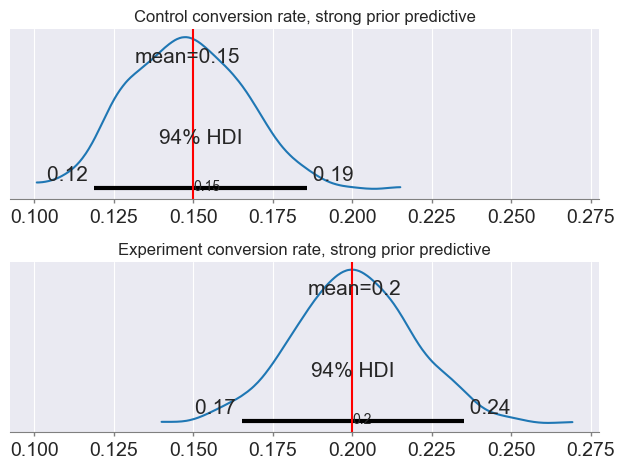

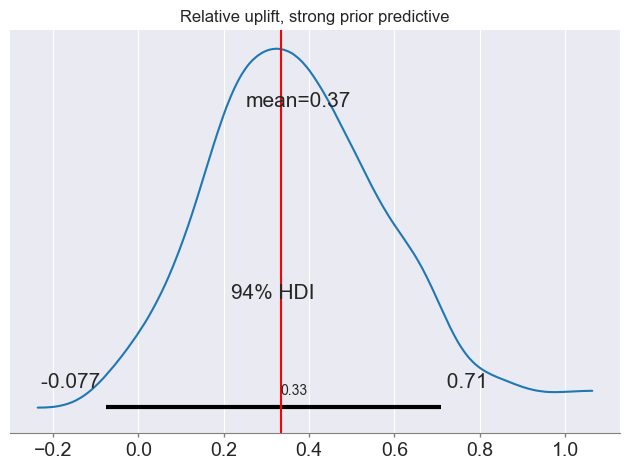

In [22]:
# Prior predictive check
strong_prior_model.plot_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate_control, conversion_rate_experiment]


c:\Users\PC\Documents\WorkLocal\DataScience\GitHub\BayesianModelingExperiments\venv\Lib\site-packages\rich\live.py:
231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


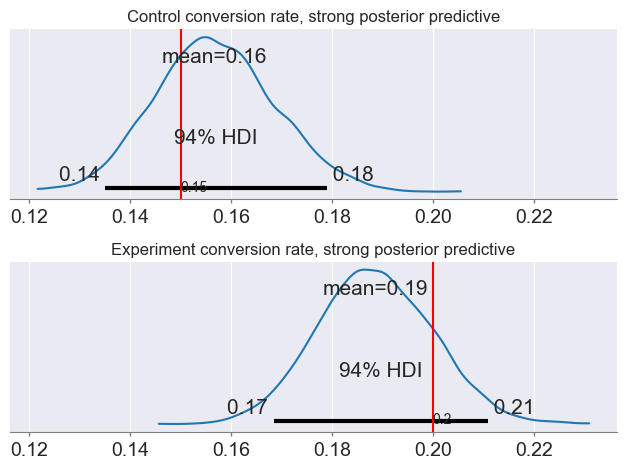

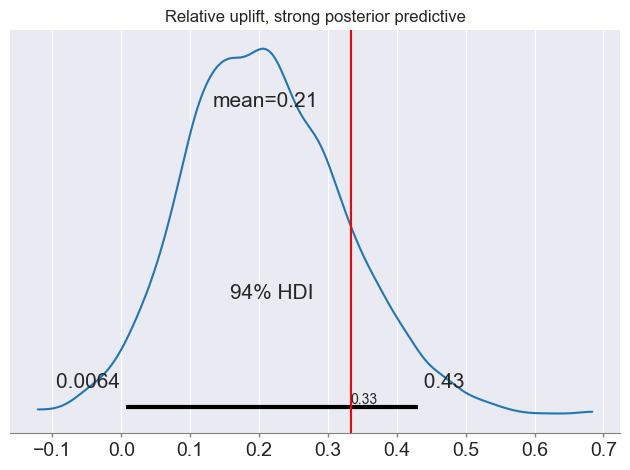

In [23]:
strong_prior_model.plot_posterior_predictive()

In [29]:
print(strong_prior_model.visitors)
print(strong_prior_model.conversions)

[621, 634]
[100, 114]


In [28]:
np.array(strong_prior_model.conversions) / np.array(strong_prior_model.visitors)

array([0.161 , 0.1798])

Despite a very strong & accurate prior, the posterior estimate ends up considerably off, because the particular sample is very noisy.